In [74]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

In [75]:
chips = pd.read_csv('chips.csv')
geyser = pd.read_csv('geyser.csv')

In [76]:
chips.head()

,x,y,class
0,0.051267,0.69956,P
1,-0.092742,0.68494,P
2,-0.213710,0.69225,P
3,-0.375000,0.50219,P
4,-0.513250,0.46564,P


In [77]:
geyser.head()

,x,y,class
0,1,4.4,N
1,1,3.9,N
2,1,4.0,P
3,1,4.0,N
4,1,3.5,N


In [78]:
chips['class'] = chips['class'].replace('P', 1)
chips['class'] = chips['class'].replace('N', -1)

geyser['class'] = geyser['class'].replace('P', 1)
geyser['class'] = geyser['class'].replace('N', -1)

In [79]:
def X_y(df: pd.DataFrame):
    return df.iloc[:, :-1].to_numpy(), df.iloc[:, -1].to_numpy()

In [80]:
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.linear_model import LogisticRegression


def plot_decision_boundary(clf, X, y, fit=True, ax=None, step=None):
    if fit:
        clf.fit(X, y)
    
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        cmap=plt.cm.Paired,
        ax=ax,
        response_method="predict",
        plot_method="contour",
        shading="auto",
        xlabel="x",
        ylabel="y",
        eps=0.5,
    )
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k", cmap=plt.cm.Paired)
    ax.set_title(f'step={step}')

In [81]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.multiclass import unique_labels

class AdaBoost(BaseEstimator, ClassifierMixin):
    def __init__(self, base, steps=100, max_depth=4, scoring=None, visualize_steps=None) -> None:
        self.base = base
        self.steps = steps
        self.max_depth = max_depth
        self.visualize_steps = visualize_steps
        self.scoring = scoring
    
    def fit(self, X, y):
        self.is_fitted_ = True
        self.classes_ = unique_labels(y)
        
        weights = np.ones(X.shape[0]) / X.shape[0]

        self.estimators_ = []
        self.alphas_ = []

        if self.visualize_steps:
            i = 0
            axes = plt.subplots(3, 3, figsize=(15, 15))[-1].ravel()
        
        if self.scoring:
            self.scores = []
            
        for step in range(self.steps):
            # Fit base model with current weights
            estimator = self.base(max_depth=self.max_depth)
            estimator.fit(X, y, sample_weight=weights)
            self.estimators_.append(estimator)

            # Calculate alpha
            pred = estimator.predict(X)
            avg_error = np.sum(weights * (y * pred < 0).astype(int))
            alpha = 0.5 * (np.log(1 - avg_error) - np.log(avg_error))
            self.alphas_.append(alpha)

            # Compute weights for samples
            weights = weights * np.exp(-alpha * y * pred)
            weights = weights / np.sum(weights)
            
            if self.visualize_steps and step in self.visualize_steps:
                plot_decision_boundary(self, X, y, fit=False, ax=axes[i], step=step)
                i += 1
            
            if self.scoring:
                self.scores.append(self.scoring(y, pred))
                
        if self.visualize_steps:
            plt.show()
        
        if self.scoring:
            plt.plot(self.scores)
            plt.xlabel('steps')
            plt.ylabel('Accuracy')
            plt.show()

        return self
        
    
    def predict(self, X):
        pred = np.zeros(X.shape[0], dtype=float)
        for alpha, estimator in zip(self.alphas_, self.estimators_):
            pred += alpha * estimator.predict(X)
        return np.sign(pred)

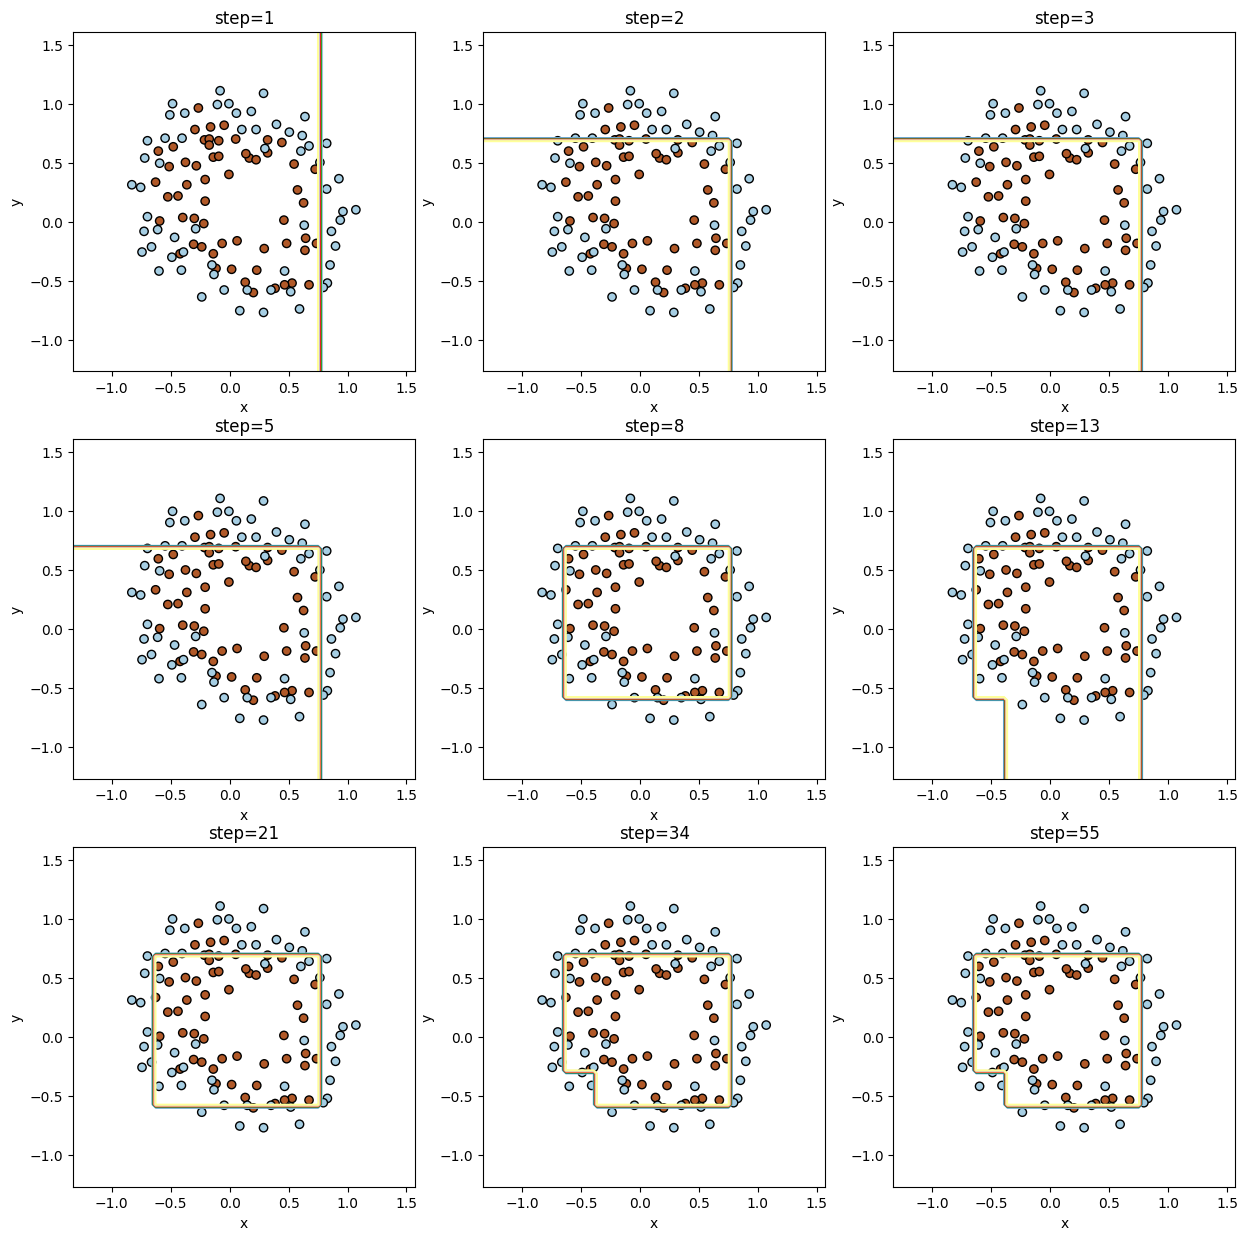

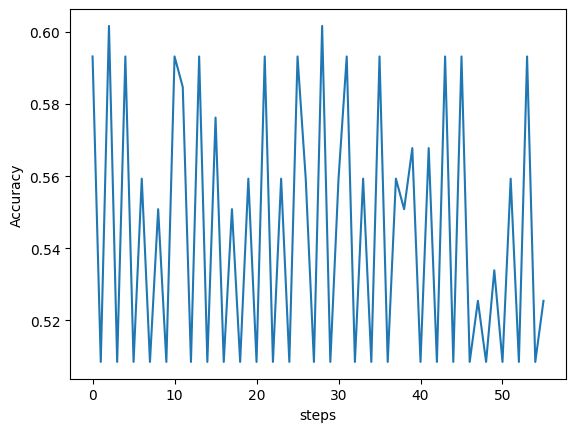

AdaBoost(base=<class 'sklearn.tree._classes.DecisionTreeClassifier'>,
         max_depth=1, scoring=<function accuracy_score at 0x0000023B7FF7ED40>,
         steps=56, visualize_steps=[1, 2, 3, 5, 8, 13, 21, 34, 55])

In [82]:
clf = AdaBoost(DecisionTreeClassifier, max_depth=1, steps=56, scoring=accuracy_score, visualize_steps=[1, 2, 3, 5, 8, 13, 21, 34, 55])
clf.fit(*X_y(chips))

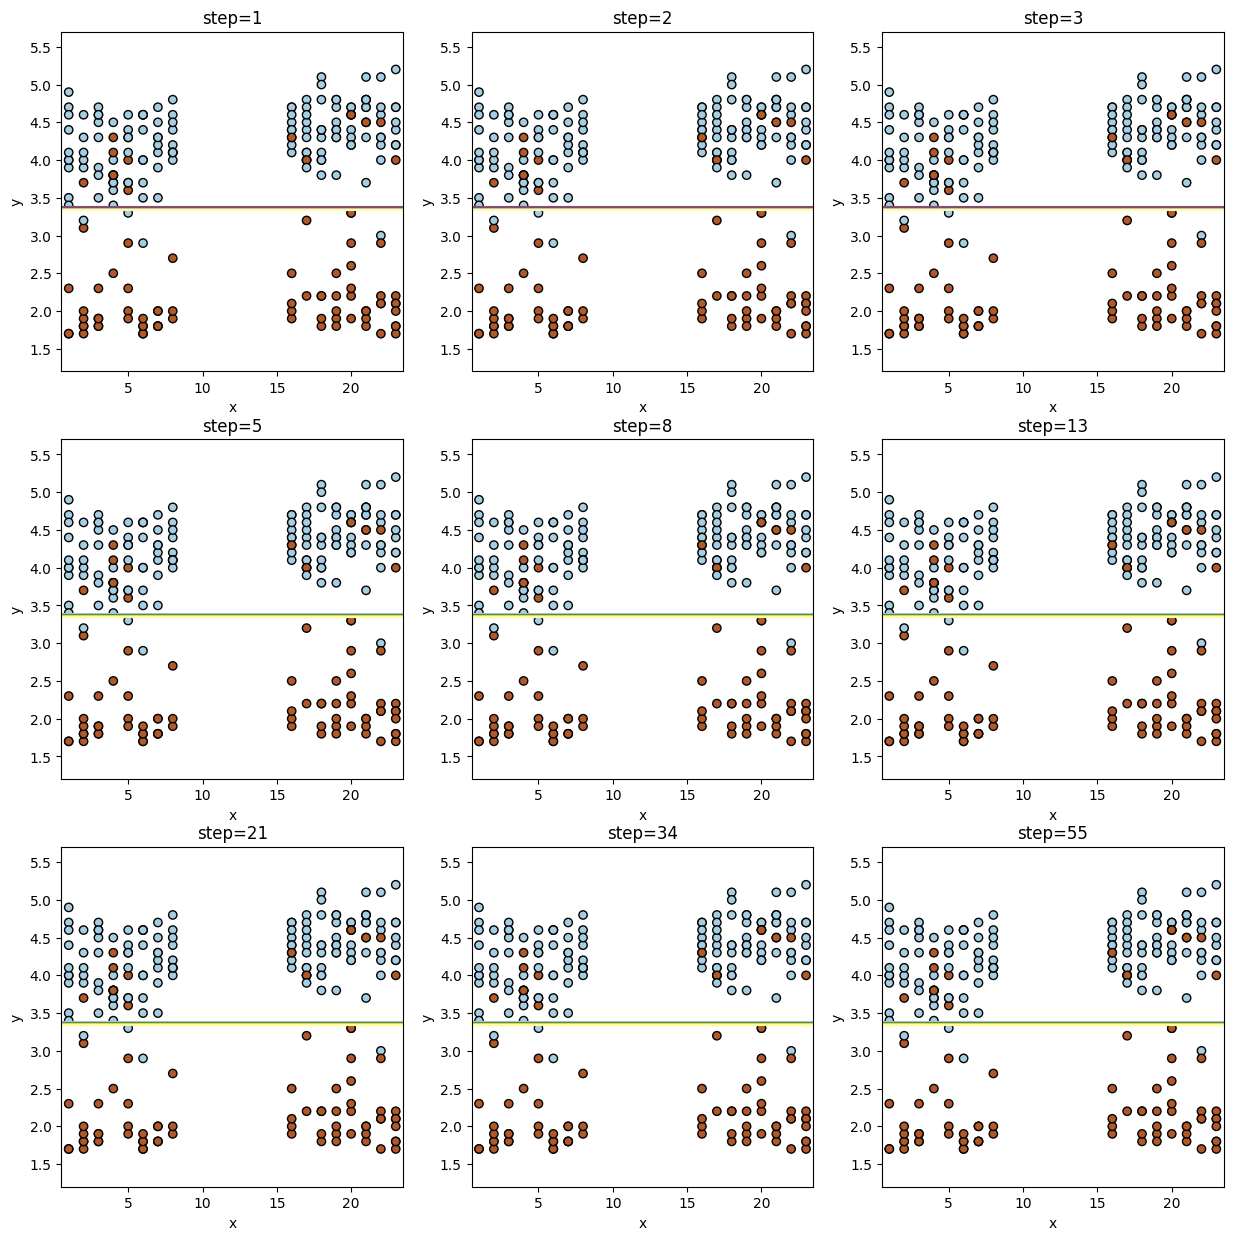

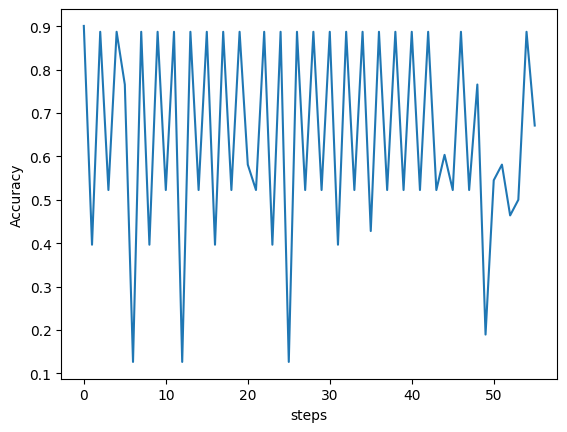

AdaBoost(base=<class 'sklearn.tree._classes.DecisionTreeClassifier'>,
         max_depth=1, scoring=<function accuracy_score at 0x0000023B7FF7ED40>,
         steps=56, visualize_steps=[1, 2, 3, 5, 8, 13, 21, 34, 55])

In [83]:
clf.fit(*X_y(geyser))

In [91]:
from sklearn.model_selection import GridSearchCV

def kfold(X, y):
    clf = AdaBoost(DecisionTreeClassifier, max_depth=4)
    param_grid = {
        'steps': range(1, 60)
    }

    grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=15, scoring='accuracy', n_jobs=-1)

    # Fit GridSearchCV
    grid_search.fit(X, y)

    # Best model result
    print("Best params:", grid_search.best_params_)
    print(f"Best score: {grid_search.best_score_}")

    # Plotting results
    results = grid_search.cv_results_
    plt.figure(figsize=(10, 5))
    plt.plot(results['param_steps'].data, results['mean_test_score'], marker='o', linestyle='-')
    plt.title('Accuracy vs Number of Steps in AdaBoost')
    plt.xlabel('steps')
    plt.ylabel('accuracy')
    plt.grid(True)
    plt.show()


Best params: {'steps': 2}
Best score: 0.7202380952380952


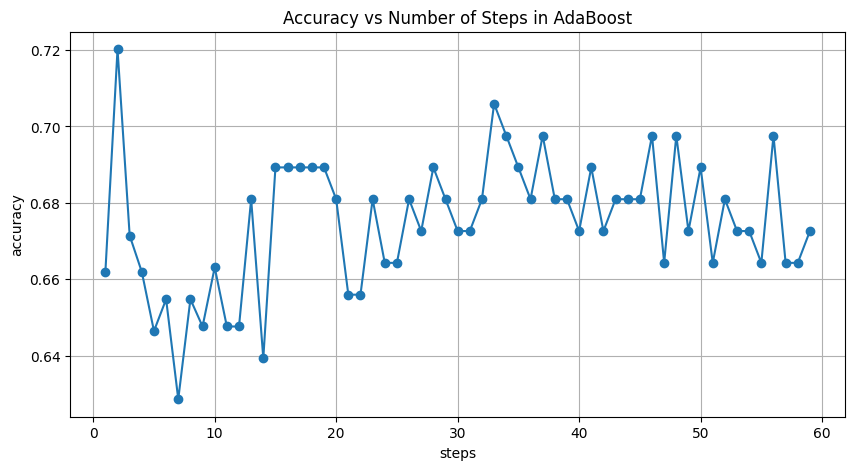

In [92]:
kfold(*X_y(chips))

Best params: {'steps': 2}
Best score: 0.86984126984127


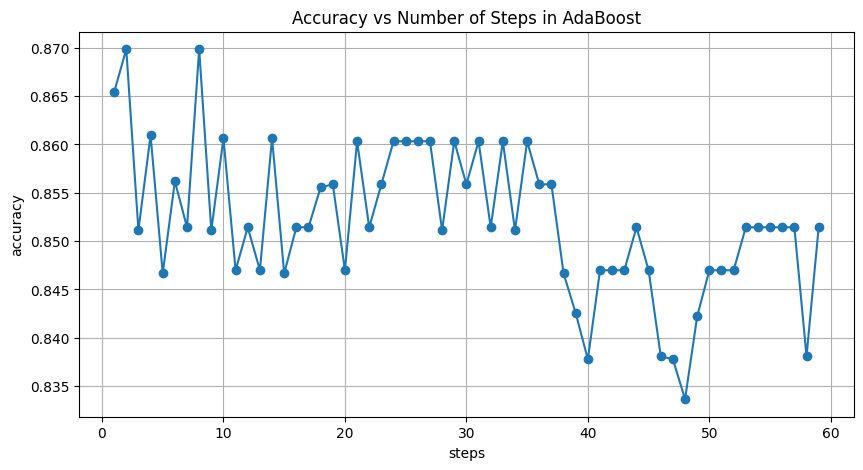

In [94]:
kfold(*X_y(geyser))